<a href="https://colab.research.google.com/github/ML-Radiology/Abdominal_MRI_series_classification/blob/main/notebooks/Driver_notebook_for_publication_results_for_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [ ]:
if COLAB_FLAG:
    %pip install pydicom==2.1.2
    %pip install monai seaborn sentence_transformers
    %git clone 'redacted name of repo here'




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
import scipy.stats as stats

warnings.filterwarnings("ignore")

In [ ]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    val_datafile = '/content/AIPI540_individual_project/data/valfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/')
    os.chdir('/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/')
    print(os.getcwd())
    print(sys.path)
    train_datafile = 'data/trainfiles.csv'
    val_datafile = 'data/valfiles.csv'
    test_datafile = 'data/testfiles.csv'

### local imports ###
#from scripts import config
from scripts.config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from scripts.config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from scripts.config import sentence_encoder, series_description_column
from scripts.utils import *

from scripts.NLP.NLP_training import train_NLP_model
from scripts.NLP.NLP_inference import get_NLP_inference
from scripts.cnn.cnn_dataset import ImgDataset
from scripts.cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from scripts.cnn.cnn_model import CustomResNet50
from scripts.cnn.cnn_data_loaders import get_data_loaders
from scripts.metadata.meta_inference import meta_inference, calc_feature_importances
from scripts.metadata.meta_training import train_fit_parameter_trial, train_meta_model, evaluate_meta_model
from scripts.fusion_model.fus_model import FusionModel
from scripts.fusion_model.fus_inference import get_fusion_inference, get_fusion_inference_from_file
from scripts.fusion_model.fus_training import train_fusion_model, CustomDataset
from scripts.model_container import ModelContainer
from scripts.process_tree import Processor


/Users/cmm/Documents/GitHub/new/AIPI540_individual_project
['/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/notebooks', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python311.zip', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11/lib-dynload', '', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11/site-packages', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/scripts', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/scripts', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/']


# Load Datasets


In [ ]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile)
#test_df

In [ ]:
# prepares the features (preprocess normalizes/binarizes/ordinalizes the columns and limits to the feature set) and gets the labels

X_train_meta, scaler = preprocess(train_df, need_fit_scaler=True, save_scaler=True)

X_val_meta, _ = preprocess(val_df, scaler)
X_test_meta, _ = preprocess(test_df, scaler)
y_train = train_df.label
y_val = val_df.label
y_test = test_df.label


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


## The Dataset

In [ ]:
train_df['label_description'] = train_df['label'].apply(lambda x: abd_label_dict[str(x)]['short'])
train_values = train_df.label_description.value_counts().sort_index()

In [ ]:
val_df['label_description'] = val_df['label'].apply(lambda x: abd_label_dict[str(x)]['short'])
val_values = val_df.label_description.value_counts().sort_index()

In [ ]:
test_df['label_description'] = test_df['label'].apply(lambda x: abd_label_dict[str(x)]['short'])
test_values = test_df.label_description.value_counts().sort_index()

In [ ]:
total_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
total_values = total_df.label_description.value_counts().sort_index()

In [ ]:
from IPython.display import display, Latex

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Train': train_values,
    'Validation': val_values,
    'Test': test_values,
    'Total': total_values
}).fillna(0).astype(int)  # Fill missing values with 0 and convert to int for clean display

counts_df
# styled_latex_table = summary_df.to_latex(index=True, column_format='lcccc',
#                                         header=True, bold_rows=True,
#                                         caption='Value Counts by Category',
#                                         label='tab:value_counts',
#                                         escape=False)
# display(Latex(styled_latex_table))


,Train,Validation,Test,Total
label_description,,,,
adc,61,17,21,99
arterial,187,49,61,297
dixon_fat,74,20,29,123
dwi,138,35,43,216
dynamic_equilibrium,92,20,22,134
dynamic_late,56,14,17,87
hepatobiliary ax,24,12,10,46
hepatobiliary cor,6,3,3,12
in_phase ax,73,19,23,115


In [ ]:
num_series_train, num_series_val, num_series_test, num_series_total = len(train_df), len(val_df), len(test_df), len(total_df)
print(f'The number of series for train, val, test and total datasets are: {num_series_train, num_series_val, num_series_test, num_series_total}')

The number of series for train, val, test and total datasets are: (1369, 354, 432, 2155)


In [ ]:
## Getting some more data about the initial dataset
#%cd 'Abdominal_MRI_dataset_split'

OG_test_df = get_dicoms('test/')
OG_train_df = get_dicoms('train/')
OG_train_df = OG_train_df[1]
OG_test_df = OG_test_df[1]


Finding DICOM files. This may take a few minutes.
Reading DICOM files with extensions .dcm, .dicom, .dcim, or .ima. This may take a few minutes, depending on the number of files to read...
Finding DICOM files. This may take a few minutes.
Reading DICOM files with extensions .dcm, .dicom, .dcim, or .ima. This may take a few minutes, depending on the number of files to read...


In [ ]:

OG_df = pd.concat([OG_train_df, OG_test_df], ignore_index=True)
OG_df = expand_filename_into_columns(OG_df, ['train_or_test','patientID', 'exam', 'series', 'image'])

## labels series have no spaces so need to match, and the patientID should be a string to match with the labels df
OG_df.series = OG_df.series.apply(lambda x: str(x).replace(' ', ''))
## patientID should be a string of a number without leading 0's
OG_df.patientID = OG_df.patientID.astype(str)
OG_df.patientID = OG_df.patientID.astype(int)
OG_df.patientID = OG_df.patientID.astype(str)
OG_df.patientID.value_counts()

patientID
37    2565
2     1962
74    1807
24    1767
88    1733
      ... 
38     810
57     801
93     655
98     619
33     490
Name: count, Length: 105, dtype: int64

In [ ]:
num_patients = OG_df['patientID'].nunique()
num_patients

105

Mean number of images per series per patient:
53.2631103074141

Median number of images per series per patient:
64.0

Standard deviation of number of images per series per patient:
24.98595598114592


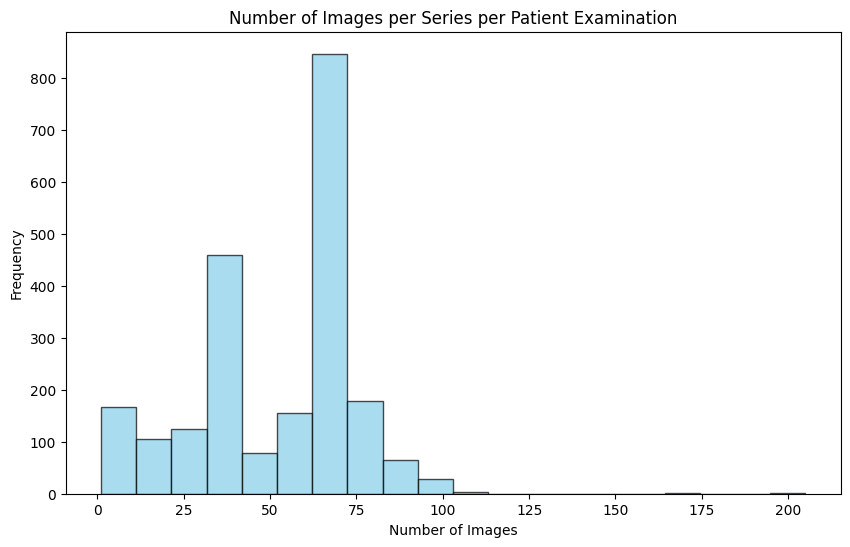

In [ ]:
# Group by both 'patientID' and 'series' and count the number of images in each series for each patient
images_per_series_per_patient = OG_df.groupby(['patientID', 'series']).size()

# Calculate mean, median, and standard deviation
mean_images_per_series_per_patient = images_per_series_per_patient.mean()
median_images_per_series_per_patient = images_per_series_per_patient.median()
std_dev_images_per_series_per_patient = images_per_series_per_patient.std()

# Print the results
print("Mean number of images per series per patient:")
print(mean_images_per_series_per_patient)
print("\nMedian number of images per series per patient:")
print(median_images_per_series_per_patient)
print("\nStandard deviation of number of images per series per patient:")
print(std_dev_images_per_series_per_patient)

# Plot histogram of the number of images per series per patient
plt.figure(figsize=(10, 6))
images_per_series_per_patient.hist(bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Number of Images per Series per Patient Examination')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.grid(False)
plt.savefig('histogram_images_per_series.tiff', dpi=300, format='tiff')
plt.show()

patientID
0                           {16, 19, 15, 3, 22, 20, 7, 18(39-76), 17, 8, 21, 14, 6, 18(1-38), 2, 13, 9, 11, 12, 5, 23}
1                        {16, 27(1-44), 15, 22, 33, 29, 28, 31, 21, 14, 32, 26, 25, 13, 27(45-88), 11, 30, 12, 24, 23}
10                             {16, 19, 15, 22, 20, 7, 10, 17, 18(41-80), 18(1-40), 8, 4, 21, 14, 6, 2, 13, 11, 12, 5}
100                            {16, 19, 15, 3, 22, 20, 18, 17(41-80), 1, 4, 21, 14, 6, 2, 13, 11, 12, 17(1-40), 24, 5}
101                              {16, 14(1-36), 19, 15, 3, 20, 7, 10, 18, 1, 17, 4, 6, 2, 13, 9, 11, 12, 14(37-72), 5}
                                                            ...                                                       
95                                   {16(1-36), 19, 15, 3, 7, 10, 18, 1, 17, 8, 4, 14, 6, 2, 13, 16(37-72), 11, 12, 5}
96     {38(39-76), 34, 22, 38(1-38), 36, 33, 29, 28, 1, 35, 41, 40, 32, 37, 39, 26, 25, 2, 13, 11, 30, 12, 27, 24, 23}
97                                 {16

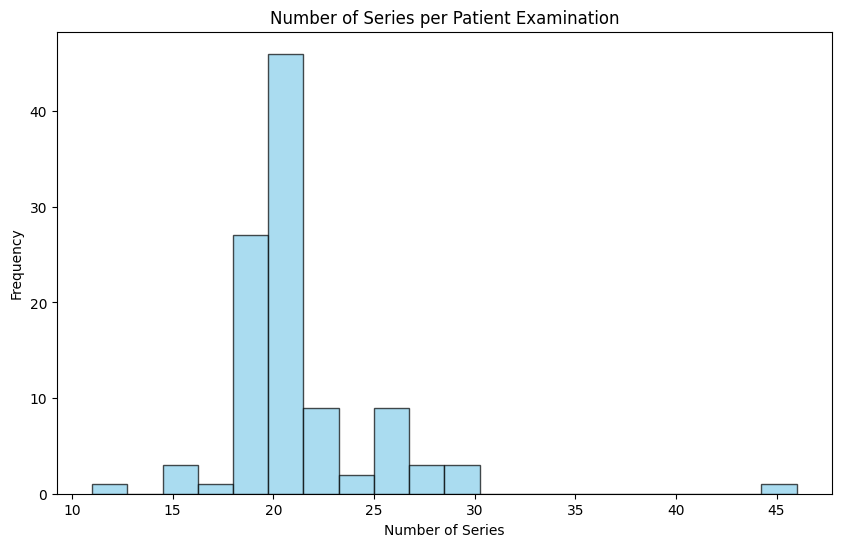

In [ ]:
# Group by 'patientID' and aggregate 'series' column into a list
series_per_patient = OG_df.groupby('patientID')['series'].apply(set)

print(series_per_patient)
num_series_per_patient = series_per_patient.apply(len)

# Calculate mean, median, and std dev
mean_num_series = num_series_per_patient.mean()
median_num_series = num_series_per_patient.median()
std_dev_num_series = num_series_per_patient.std()

print("Mean number of series per patient:", mean_num_series)
print("Median number of series per patient:", median_num_series)
print("Standard deviation of number of series per patient:", std_dev_num_series)

# Plot histogram of the number of images per series per patient
plt.figure(figsize=(10, 6))
num_series_per_patient.hist(bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Number of Series per Patient Examination')
plt.xlabel('Number of Series')
plt.ylabel('Frequency')
plt.grid(False)
plt.savefig('histogram_series_per_patient.tiff', dpi=300, format='tiff')
plt.show()

In [ ]:
labels_df = labels_from_file('labels_chad_modified_reduceUnk.txt', [['patientID', 'exam', 'series', 'label']])
labels_df

,patientID,exam,series,label
0,85,exam1,4,14
1,85,exam1,3,19
2,85,exam1,10,9
3,85,exam1,22,16
4,85,exam1,21,6
...,...,...,...,...
2210,83,exam1,20,16
2211,83,exam1,8,9
2212,83,exam1,18,16
2213,83,exam1,17,0


In [ ]:
labels_df.patientID.value_counts()

(patientID,)
37              46
5               29
24              29
88              29
2               28
                ..
57              17
60              16
39              16
98              15
33              11
Name: count, Length: 105, dtype: int64

## Get Inferences from Saved Models

In [ ]:
# Load the pickled model
with open(model_paths['meta'], 'rb') as file:
    meta_model = pickle.load(file)

with open(model_paths['scaler'], 'rb') as file:
    scaler = pickle.load(file)



### First, some dtails about the RF model

In [ ]:
## details about RF model:
meta_model

RandomForestClassifier(bootstrap=False, max_depth=371, max_features='auto',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=373, n_jobs=2, random_state=0)

In [ ]:
## list of 10 most important features in descending order
important_features_dict = {}
for idx, val in enumerate(meta_model.feature_importances_):
    important_features_dict[idx] = val
important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=True)
#print(important_features_list[:10])
print([feats[x] for x in important_features_list[:10]])

['EchoTime', 'RepetitionTime', 'SliceThickness', 'ContrastBolusAgent', 'opt_FSP_GEMS', 'var_TOF', 'PixelSpacing', 'EchoTrainLength', 'opt_B', 'seq_IR']


### Now, get the predictions from the RF model

In [ ]:
# gets predictions, probabilitie, the truth label, and accuracies for the training, validation, and test datasets

Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, scaler, meta_model, feats_to_keep)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, scaler, meta_model, feats_to_keep)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, scaler, meta_model, feats_to_keep)


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [ ]:
# create dataframes from the data above

meta_train_results_df = make_results_df(Tpreds, Tprobs, Ty, train_df)
meta_val_results_df = make_results_df(Vpreds, Vprobs, Vy, val_df)
meta_test_results_df = make_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        61
           arterial       0.81      0.98      0.89       187
       dynamic_late       0.96      0.93      0.95        56
             t2 cor       0.97      0.99      0.98        70
                dwi       0.99      1.00      0.99       137
              t2 ax       0.99      0.98      0.99       140
                dwi       0.00      0.00      0.00         1
          dixon_fat       0.84      0.85      0.85        74
   hepatobiliary ax       0.79      0.46      0.58        24
  hepatobiliary cor       1.00      0.50      0.67         6
        in_phase ax       0.92      0.99      0.95        73
       in_phase cor       0.00      0.00      0.00         1
dynamic_equilibrium       0.59      0.65      0.62        92
                loc       1.00      1.00      1.00        66
               mrcp       1.00      1.00      1.00       106
   opposed_phase ax    

<Figure size 2500x2500 with 0 Axes>

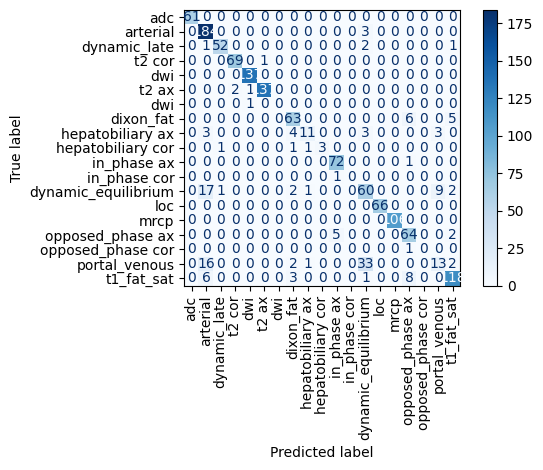

In [ ]:
metadata_train_results = display_and_save_results2(meta_train_results_df.preds, meta_train_results_df.true, fn='meta_train', saveflag=False)

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        17
           arterial       0.89      0.82      0.85        49
       dynamic_late       0.86      0.86      0.86        14
             t2 cor       1.00      1.00      1.00        18
                dwi       1.00      1.00      1.00        35
              t2 ax       1.00      1.00      1.00        34
          dixon_fat       0.86      0.90      0.88        20
   hepatobiliary ax       0.38      0.25      0.30        12
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       1.00      1.00      1.00        19
dynamic_equilibrium       0.34      0.65      0.45        20
                loc       1.00      1.00      1.00        17
               mrcp       1.00      1.00      1.00        22
   opposed_phase ax       1.00      0.79      0.88        19
      portal_venous       0.33      0.16      0.21        19
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

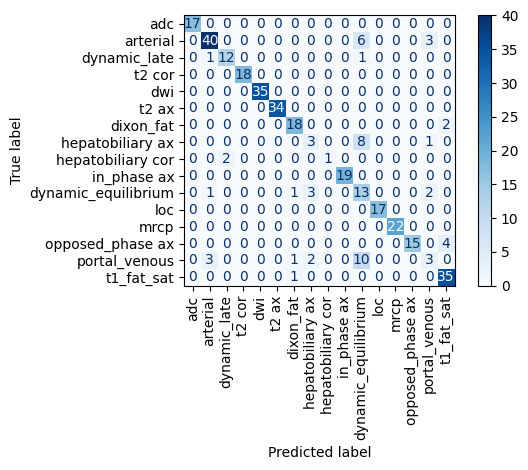

In [ ]:
metadata_val_results = display_and_save_results2(meta_val_results_df.preds, meta_val_results_df.true, fn='meta_val', saveflag=False)

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.77      0.93      0.84        61
       dynamic_late       0.94      0.94      0.94        17
             t2 cor       0.96      1.00      0.98        22
                dwi       1.00      1.00      1.00        43
              t2 ax       0.98      1.00      0.99        42
          dixon_fat       0.89      0.83      0.86        29
   hepatobiliary ax       0.67      0.60      0.63        10
  hepatobiliary cor       1.00      0.67      0.80         3
        in_phase ax       1.00      1.00      1.00        23
dynamic_equilibrium       0.60      0.27      0.37        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      0.93      0.96        28
   opposed_phase ax       0.66      0.91      0.76        23
      portal_venous       0.44      0.35      0.39        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

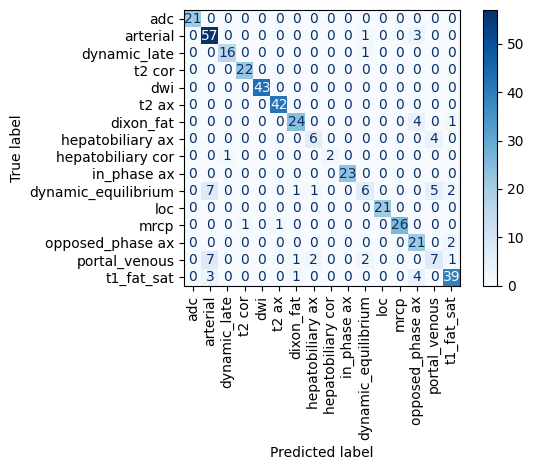

In [ ]:
metadata_results = display_and_save_results2(meta_test_results_df.preds, meta_test_results_df.true, fn='meta', saveflag=False)

### Bootstrapping results of the metadata model

In [ ]:
# for metadata model only
meta_acc_int, meta_f1_int, meta_f1_overall_int, acc_list, f1_list = bootstrap_results(meta_test_results_df, 'preds', 'true')


overall_f1_scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

### Now, getting the pixel-based models

In [ ]:
sys.path.append('/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/')
os.chdir('/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/')
print(os.getcwd())
print(sys.path)
!ls

/Users/cmm/Documents/GitHub/new/AIPI540_individual_project
['/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/notebooks', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python311.zip', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11/lib-dynload', '', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11/site-packages', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/scripts', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/scripts', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/']
Dockerfile           current_packages.txt requirements.txt
README.md            data                 requirements_old.txt
app                  models               scripts
assets               notebooks            tree_

In [ ]:

# image based models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pix = CustomResNet50(19)

# Load the saved state dictionary
saved_state_dict = torch.load('models/pixel_model_041623.pth', map_location=device)

# Modify the keys to add the 'resnet50.' prefix
modified_state_dict = {f'resnet50.{k}': v for k, v in saved_state_dict.items()}

# Load the modified state dictionary into the current model
model_pix.load_state_dict(modified_state_dict)
model_pix = model_pix.to(device)


In [ ]:
# get the inference results on the ResNet50 pixel-based model

pixel_train_preds, pixel_train_probs = pixel_inference(model_pix, train_df.fname.tolist())
pixel_val_preds, pixel_val_probs = pixel_inference(model_pix, val_df.fname.to_list())
pixel_test_preds, pixel_test_probs = pixel_inference(model_pix, test_df.fname.to_list())

In [ ]:
# put the inference results into a dataframe

pixel_train_results_df = make_results_df(pixel_train_preds, pixel_train_probs, Ty, train_df)
pixel_val_results_df = make_results_df(pixel_val_preds, pixel_val_probs, Vy, val_df)
pixel_test_results_df = make_results_df(pixel_test_preds, pixel_test_probs, TEy, test_df)


                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.82      0.84      0.83        61
       dynamic_late       0.89      1.00      0.94        17
             t2 cor       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
              t2 ax       1.00      0.98      0.99        42
          dixon_fat       1.00      1.00      1.00        29
   hepatobiliary ax       0.00      0.00      0.00        10
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       1.00      0.83      0.90        23
dynamic_equilibrium       0.57      0.36      0.44        22
                loc       1.00      0.95      0.98        21
               mrcp       1.00      1.00      1.00        28
   opposed_phase ax       0.81      0.96      0.88        23
      portal_venous       0.43      0.75      0.55        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

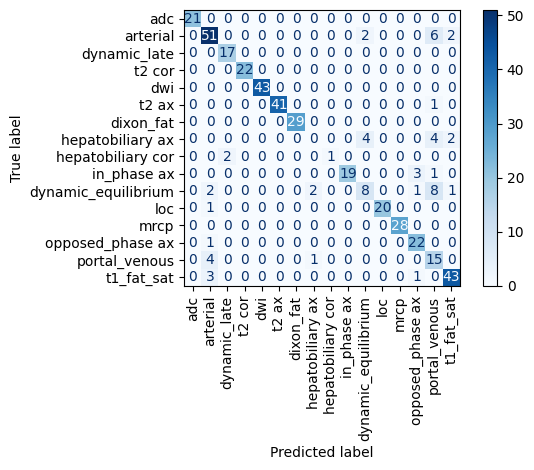

In [ ]:
resnet50_results = display_and_save_results2(pixel_test_results_df.preds, pixel_test_results_df.true, fn='pixel', saveflag=False)

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.93      0.84      0.88        61
       dynamic_late       0.85      1.00      0.92        17
             t2 cor       0.95      0.95      0.95        22
                dwi       0.93      1.00      0.97        43
              t2 ax       1.00      0.93      0.96        42
          dixon_fat       1.00      1.00      1.00        29
   hepatobiliary ax       0.50      0.10      0.17        10
  hepatobiliary cor       0.00      0.00      0.00         3
        in_phase ax       0.96      0.96      0.96        23
dynamic_equilibrium       0.56      0.82      0.67        22
                loc       0.95      0.95      0.95        21
               mrcp       1.00      0.96      0.98        28
   opposed_phase ax       0.96      1.00      0.98        23
      portal_venous       0.60      0.75      0.67        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

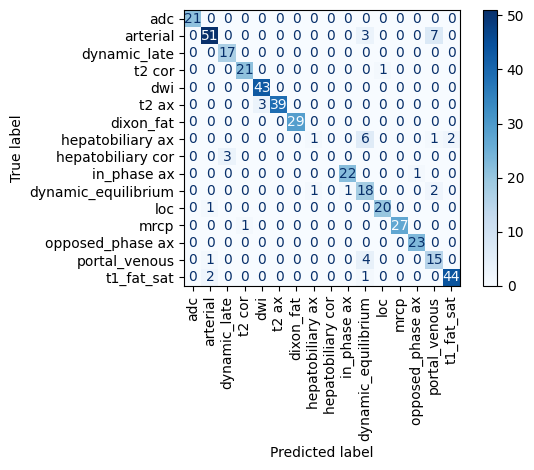

In [ ]:

# now getting inference for the trained DenseNet121 model

model_dense = load_pixel_model('models/DenseNet_model.pth', model_type='DenseNet')
model_dense.to(device)
dense_test_preds, dense_test_probs = pixel_inference(model_dense, test_df.fname.to_list())
dense_test_results_df = make_results_df(dense_test_preds, pixel_test_probs, TEy, test_df)
densenet_results = display_and_save_results2(dense_test_results_df.preds, dense_test_results_df.true, fn='dense', saveflag=False)

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        61
           arterial       1.00      1.00      1.00       187
       dynamic_late       0.98      1.00      0.99        56
             t2 cor       1.00      1.00      1.00        70
                dwi       1.00      1.00      1.00       137
              t2 ax       1.00      1.00      1.00       140
                dwi       1.00      1.00      1.00         1
          dixon_fat       1.00      1.00      1.00        74
   hepatobiliary ax       1.00      1.00      1.00        24
  hepatobiliary cor       1.00      0.83      0.91         6
        in_phase ax       1.00      1.00      1.00        73
       in_phase cor       1.00      1.00      1.00         1
dynamic_equilibrium       1.00      1.00      1.00        92
                loc       1.00      1.00      1.00        66
               mrcp       1.00      1.00      1.00       106
   opposed_phase ax    

<Figure size 2500x2500 with 0 Axes>

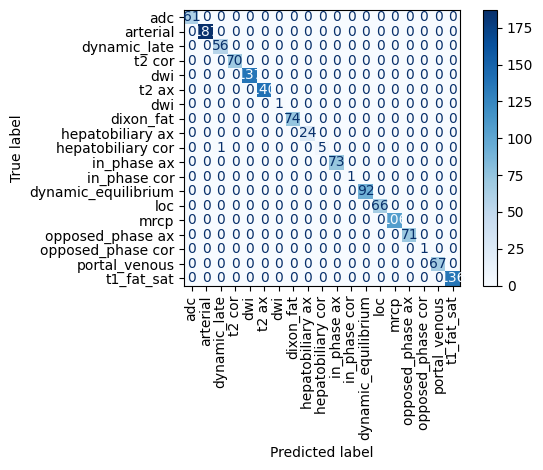

In [ ]:
dense_train_preds, dense_train_probs = pixel_inference(model_dense, train_df.fname.to_list())
dense_train_results_df = make_results_df(dense_train_preds, dense_train_probs, Ty, train_df)
densenet__train_results = display_and_save_results2(dense_train_results_df.preds, dense_train_results_df.true, fn='dense_train', saveflag=False)

                     precision    recall  f1-score   support

                adc       0.89      1.00      0.94        17
           arterial       0.98      0.86      0.91        49
       dynamic_late       0.88      1.00      0.93        14
             t2 cor       0.94      0.94      0.94        18
                dwi       0.94      0.91      0.93        35
              t2 ax       0.94      0.97      0.96        34
          dixon_fat       1.00      0.90      0.95        20
   hepatobiliary ax       0.00      0.00      0.00        12
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       0.90      0.95      0.92        19
dynamic_equilibrium       0.42      0.70      0.53        20
                loc       1.00      0.94      0.97        17
               mrcp       0.95      0.95      0.95        22
   opposed_phase ax       1.00      0.95      0.97        19
      portal_venous       0.64      0.47      0.55        19
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

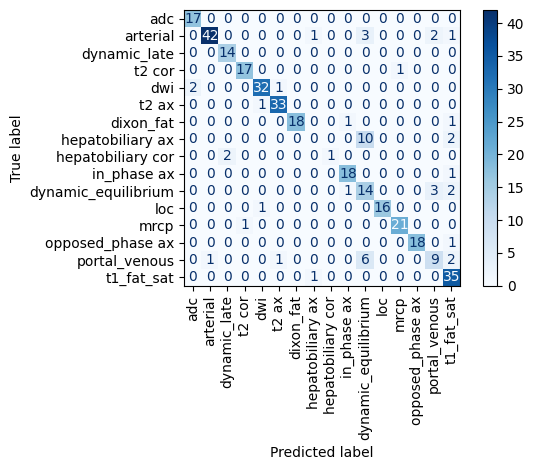

In [ ]:
dense_val_preds, dense_val_probs = pixel_inference(model_dense, val_df.fname.to_list())
dense_val_results_df = make_results_df(dense_val_preds, dense_val_probs, Vy, val_df)
densenet__val_results = display_and_save_results2(dense_val_results_df.preds, dense_val_results_df.true, fn='dense_val', saveflag=False)

In [ ]:
dense_acc_int, dense_f1_int, dense_f1_overall_int, dense_acc_list, dense_f1_list = bootstrap_results(dense_test_results_df, 'preds', 'true')


overall_f1_scores: [0.9565217391304348, 0.9500000000000001, 0.9859154929577464, 1.0, 0.9767441860465117, 1.0, 0.9795918367346939, 0.9565217391304348, 1.0, 0.9, 0.9767441860465117, 0.9454545454545454, 0.9767441860465117, 0.9655172413793104, 1.0, 1.0, 0.9743589743589743, 0.9795918367346939, 0.975609756097561, 1.0, 1.0, 0.9777777777777777, 0.9090909090909091, 0.983050847457627, 0.9122807017543859, 0.9787234042553191, 0.9545454545454545, 0.9375, 0.9523809523809523, 0.9565217391304348, 0.9787234042553191, 1.0, 0.8936170212765957, 1.0, 0.9268292682926829, 0.9600000000000001, 0.9411764705882353, 0.9523809523809523, 0.9142857142857143, 1.0, 1.0, 0.9565217391304348, 0.9714285714285714, 1.0, 0.9787234042553191, 0.9545454545454545, 0.9500000000000001, 0.9615384615384615, 0.9600000000000001, 0.9767441860465117, 1.0, 0.9090909090909091, 0.9565217391304348, 0.9642857142857143, 0.972972972972973, 1.0, 0.9189189189189189, 0.9189189189189189, 1.0, 1.0, 0.9787234042553191, 0.9411764705882353, 0.91666666

Computing and displaying combined model for the test dataset:
                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.93      0.90      0.92        61
       dynamic_late       0.89      1.00      0.94        17
             t2 cor       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
              t2 ax       1.00      1.00      1.00        42
          dixon_fat       1.00      1.00      1.00        29
   hepatobiliary ax       0.50      0.10      0.17        10
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       0.96      0.96      0.96        23
dynamic_equilibrium       0.58      0.82      0.68        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      1.00      1.00        28
   opposed_phase ax       0.96      1.00      0.98        23
      portal_venous   

<Figure size 2500x2500 with 0 Axes>

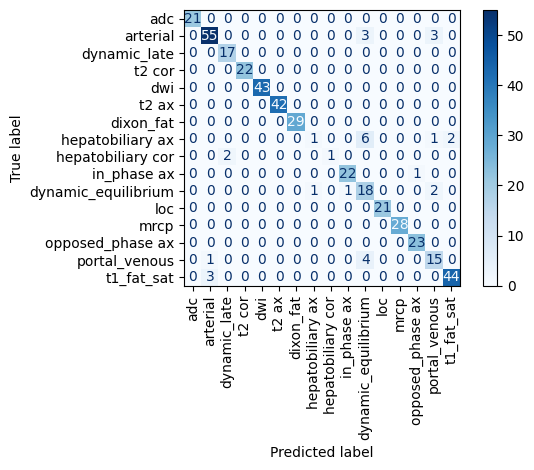

Computing and displaying combined model for the train dataset:
                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        61
           arterial       0.99      1.00      1.00       187
       dynamic_late       0.97      1.00      0.98        56
             t2 cor       1.00      1.00      1.00        70
                dwi       1.00      1.00      1.00       137
              t2 ax       1.00      1.00      1.00       140
                dwi       1.00      1.00      1.00         1
          dixon_fat       1.00      1.00      1.00        74
   hepatobiliary ax       1.00      1.00      1.00        24
  hepatobiliary cor       1.00      0.67      0.80         6
        in_phase ax       1.00      1.00      1.00        73
       in_phase cor       1.00      1.00      1.00         1
dynamic_equilibrium       1.00      1.00      1.00        92
                loc       1.00      1.00      1.00        66
               mrcp  

<Figure size 2500x2500 with 0 Axes>

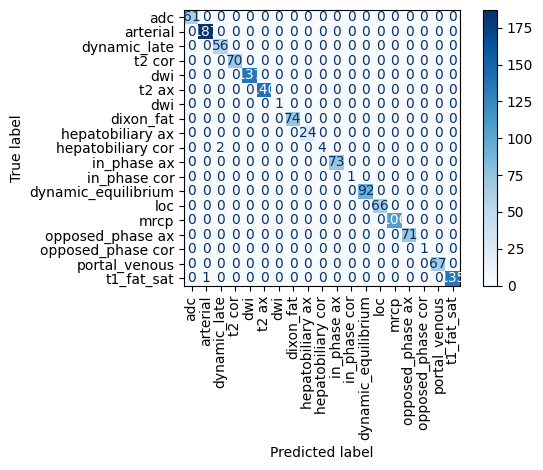

Computing and displaying combined model for the val dataset:
                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        17
           arterial       0.98      0.94      0.96        49
       dynamic_late       0.88      1.00      0.93        14
             t2 cor       1.00      1.00      1.00        18
                dwi       1.00      1.00      1.00        35
              t2 ax       0.97      1.00      0.99        34
          dixon_fat       1.00      0.95      0.97        20
   hepatobiliary ax       0.00      0.00      0.00        12
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       0.90      1.00      0.95        19
dynamic_equilibrium       0.47      0.70      0.56        20
                loc       1.00      1.00      1.00        17
               mrcp       1.00      1.00      1.00        22
   opposed_phase ax       1.00      0.95      0.97        19
      portal_venous    

<Figure size 2500x2500 with 0 Axes>

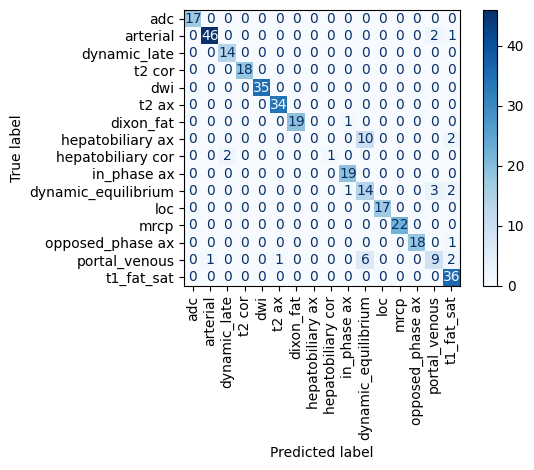

In [ ]:
### manually creating the preds and probs for the densenet model data combining for meta<70
def heuristic_model(meta_df, pixel_df, confidence=0.7, saveflag=False):
    df1 = pixel_df.copy()
    df1['pixel_preds'] = df1['preds']
    df1 = df1.drop('preds', axis=1)
    df1 = df1.drop('probs', axis=1)

    df2 = meta_df.merge(df1, how = 'left', on = ['series', 'patientID'])
    df2['meta_confidence'] = df2['probs'].apply(lambda x: max(x))
    df2.loc[df2['meta_confidence']<confidence, 'preds']=df2['pixel_preds']
    df2.preds=df2.preds.astype('int')
    heuristic_results_df = display_and_save_results2(df2.preds, df2.true_x, fn='dense70', saveflag = saveflag)

    return heuristic_results_df
print('Computing and displaying combined model for the test dataset:')
dense70_test_results = heuristic_model(meta_test_results_df, dense_test_results_df)

print('Computing and displaying combined model for the train dataset:')
dense70_train_restults = heuristic_model(meta_train_results_df, dense_train_results_df)

print('Computing and displaying combined model for the val dataset:')
dense70_val_results = heuristic_model(meta_val_results_df, dense_val_results_df)



In [ ]:
# for densenet for meta<70
dense70_acc_int, dense70_f1_int, dense70_f1_overall_int, dense70_acc_list, dense70_f1_list = bootstrap_results(dense70_df, 'preds', 'true_x')


overall_f1_scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

### Getting NLP inference


In [ ]:
# Load the pickled model
with open('models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
senttrans_model = SentenceTransformer(sentence_encoder, device=device)



In [ ]:
#from NLP.NLP_training import train_NLP_model
train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, text_model_T = train_NLP_model(train_df, val_df, test_df, senttrans_model=senttrans_model)
print(train_acc, val_acc, test_acc)

Accuracy on the training set is 0.953
size of preds_val is  354
Accuracy on the val set is 0.960
Accuracy on the test set is 0.963
0.9525200876552228 0.96045197740113 0.9629629629629629


In [ ]:

nlp_test_preds, nlp_test_probs = get_NLP_inference(NLP_model, test_df.fname.tolist())
# #nlp_train_preds, nlp_train_probs = get_NLP_inference(NLP_model, train_df.fname.tolist())
# #nlp_val_preds, nlp_val_probs = get_NLP_inference(NLP_model, val_df.fname.tolist())


/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_spli

In [ ]:
print(classification_report(nlp_test_preds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.98      0.95      0.97        63
           6       1.00      0.85      0.92        20
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       0.86      1.00      0.93        25
          12       0.60      1.00      0.75         6
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00        23
          16       1.00      0.81      0.90        27
          17       1.00      1.00      1.00        21
          18       0.96      1.00      0.98        27
          19       1.00      1.00      1.00        23
          23       1.00      0.91      0.95        22
          25       0.94      0.96      0.95        46

    accuracy                           0.96       432
   macro avg       0.90   

In [ ]:
# nlp_train_results_df = make_results_df(nlp_train_preds, nlp_train_probs, Ty, train_df)
# nlp_val_results_df = make_results_df(nlp_val_preds, nlp_val_probs, Vy, val_df)
nlp_test_results_df = make_results_df(nlp_test_preds, nlp_test_probs, TEy, test_df)

# #change names of preds, probs
# for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
# #    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)


## Create fusion model

In [ ]:

with open('data/fusion_train.pkl', 'rb') as file:
    ftrain = pd.read_pickle(file)

with open('data/fusion_val.pkl', 'rb') as file:
    fval = pd.read_pickle(file)

with open('data/fusion_test.pkl', 'rb') as file:
    ftest = pd.read_pickle(file)


#adjust the labels to consecutive numbers 0-18 and storing the original labels into 'class'
ftest['class'] = ftest['true']
ftrain['class'] = ftrain['true']
fval['class'] = fval['true']

ftest['true'] = ftest['true'].apply(lambda x: classes.index(x))
ftrain['true'] = ftrain['true'].apply(lambda x: classes.index(x))
fval['true'] = fval['true'].apply(lambda x: classes.index(x))

# get model container for the base models
model_container=ModelContainer()
model_containerDense = ModelContainer()
model_containerDense.cnn_model = model_dense

#  Instantiate FusionModel
fusion_model = FusionModel(model_containerDense, pretrained=False)
fusion_model_no_nlp = FusionModel(model_containerDense, pretrained=False, include_nlp=False)


# Define the loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)
p_optimizer = optim.Adam(fusion_model_no_nlp.parameters(), lr=0.001)


train_dataset = CustomDataset(ftrain)
val_dataset = CustomDataset(fval)
test_dataset = CustomDataset(ftest)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)




In [ ]:
# Loading trained fusion model to get predictions
# Instantiating models

Fmodel = FusionModel(model_containerDense)
Fmodel_no_nlp = FusionModel(model_containerDense, include_nlp=False)

# Load the saved state_dict (model weights)
saved_model_weights = torch.load('models/fusion_model_weightsDense20230919.pth')
saved_model_weights_no_nlp = torch.load('models/fusion_model_weights_no_nlpDense20230919.pth')

# Load the state_dict into the model
Fmodel.load_state_dict(saved_model_weights)
Fmodel_no_nlp.load_state_dict(saved_model_weights_no_nlp)


<All keys matched successfully>

In [ ]:



def compare_fusion_models(data, y_true, fus_model1, fus_model2):

    # Set the model to evaluation mode
    fus_model1.eval()
    fus_model2.eval()


    predictions1 = []
    probs1 = []

    predictions2 = []
    probs2 = []


    for index, row in data.iterrows():
        pred1, prob1, ts_df1 = fus_model1.get_fusion_inference(row)
        predictions1.append(pred1)
        probs1.append(prob1)


        pred2, prob2, ts_df2 = fus_model2.get_fusion_inference(row)
        predictions2.append(pred2)
        probs2.append(prob2)

    comparison_fusion_df = pd.DataFrame({'preds': predictions1, 'probs': probs1, 'preds2': predictions2, 'probs2': probs2, 'true': TEy})
    accuracy1 = np.mean(comparison_fusion_df.preds==comparison_fusion_df.true)
    accuracy2 = np.mean(comparison_fusion_df.preds2== comparison_fusion_df.true)

    print('The accuracies of models 1 and 2 are: ', np.round(accuracy1,3), np.round(accuracy2,3))


    return comparison_fusion_df, accuracy1, accuracy2, predictions1, predictions2


In [ ]:
# comparison_df, acc1, acc2, pred1, pred2 = compare_fusion_models(X_test_meta, TEy, Fmodel, Fmodel_no_nlp)

In [ ]:
# ### getting results for the nlp fusion test for display
# fusion_results_df = dense_test_results_df.copy()
# fusion_results_df['fusion_preds'] = comparison_df['preds2'].values
# fusion_ = display_and_save_results(fusion_results_df.fusion_preds, fusion_results_df.true, fn='fusion_no_nlp', saveflag=False)


In [ ]:
## now testing out the heuristic version incorporated into fus_inference.py

h_preds = []
h_probs = []

for index, row in X_test_meta.iterrows():
    h_pred, h_prob, h_ts_df1 = Fmodel.get_fusion_inference(row, use_heuristic=True)
    h_preds.append(h_pred)

    h_probs.append(h_prob)


heuristic_df = pd.DataFrame({'preds': h_preds, 'probs': h_probs, 'true': TEy})
h_accuracy = np.mean(heuristic_df.preds==heuristic_df.true)

print(h_accuracy)

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_spli